# Model for Recognizing Handwritten Digits

In [81]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub

import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
from keras.utils import np_utils

from tqdm import tqdm

import os
for dirname, _, filenames in os.walk('dataset'): #See all files
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset\emnist-balanced-mapping.txt
dataset\emnist-balanced-test.csv
dataset\emnist-balanced-train.csv
dataset\emnist-byclass-mapping.txt
dataset\emnist-byclass-test.csv
dataset\emnist-byclass-train.csv
dataset\emnist-bymerge-mapping.txt
dataset\emnist-bymerge-test.csv
dataset\emnist-bymerge-train.csv
dataset\emnist-digits-mapping.txt
dataset\emnist-digits-test.csv
dataset\emnist-digits-train.csv
dataset\emnist-letters-mapping.txt
dataset\emnist-letters-test.csv
dataset\emnist-letters-train.csv
dataset\emnist-mnist-mapping.txt
dataset\emnist-mnist-test.csv
dataset\emnist-mnist-train.csv
dataset\emnist_source_files\emnist-balanced-test-images-idx3-ubyte
dataset\emnist_source_files\emnist-balanced-test-labels-idx1-ubyte
dataset\emnist_source_files\emnist-balanced-train-images-idx3-ubyte
dataset\emnist_source_files\emnist-balanced-train-labels-idx1-ubyte
dataset\emnist_source_files\emnist-byclass-test-images-idx3-ubyte
dataset\emnist_source_files\emnist-byclass-test-labels-idx1-ubyte
data

## Part One: Loading the training data

In [82]:
train_df = pd.read_csv('dataset/emnist-balanced-train.csv',
                       header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
train_df.shape

(112800, 785)

### Splitting the data into features and labels

In [84]:
X_train = train_df.loc[:, 1:]
y_train = train_df.loc[:, 0]
X_train.shape, y_train.shape

((112800, 784), (112800,))

In [85]:
X_train.head()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
y_train.head()

0    45
1    36
2    43
3    15
4     4
Name: 0, dtype: int64

### Creating the label dictionary
Maps from outputs to letters

In [87]:
label_map = pd.read_csv("dataset/emnist-balanced-mapping.txt",
                        delimiter=' ',
                        index_col=0,
                        header=None,
                        squeeze=True)
label_map.head()

0
0    48
1    49
2    50
3    51
4    52
Name: 1, dtype: int64

In [88]:
label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

## Part Two: Visualizing the training data

In [89]:
# Sample entry number 42
sample_image = X_train.iloc[42]
sample_label = y_train.iloc[42]
sample_image.shape, sample_label

((784,), 23)

Label entry 42: N


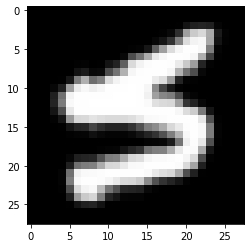

In [90]:
W = 28
H = 28
print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(sample_image.values.reshape(W, H), cmap=plt.cm.gray)
plt.show()

This doesnt look like a N. We probably need to rotate the images.

Label entry 42: N


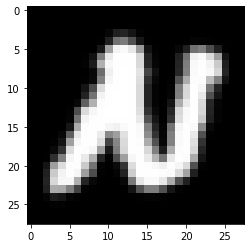

In [91]:
def reshape_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image


print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(reshape_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()

That looks much closer, but maybe this is an outlier? We will need to visualize some other images to check

In [92]:
train = np.apply_along_axis(reshape_and_rotate, 1, X_train.values) # X_train is now a numpy array
train.shape

(112800, 28, 28)

We visualize some more images to check that rotating was correct

Label entry 42: N


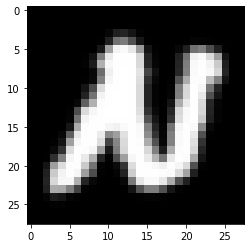

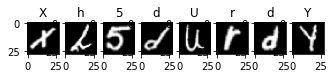

In [93]:
sample_image = train[42]
sample_label = y_train.iloc[42]
print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(sample_image.reshape(W, H), cmap=plt.cm.gray)
plt.show()

for i in range(100, 108):
    plt.subplot(390 + (i + 1))
    plt.imshow(train[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_train[i]])

Looks good!

### Part Three: Feature Engineering

First we normalize the data to between 0 and 1

In [94]:
train = train.astype('float32') / 255

One hot encode the labels

In [95]:
number_of_classes = y_train.nunique()
number_of_classes

47

In [96]:
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_train.shape

(112800, 47)

In [97]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Next we reshape the input to fit model

In [98]:
train = train.reshape(-1, W, H, 1)
train.shape

(112800, 28, 28, 1)

## Part Four: Building the model

Here we will finally create our model!

We will be using three convolution layers and two dense layers.

In [99]:
model = Sequential()

model = tf.keras.models.Sequential([

    # first convolution
    tf.keras.layers.Conv2D(8, (3, 3),
                           activation='relu'),  # applies kernels to our data
    tf.keras.layers.MaxPooling2D(2, 2),  # reduce dimension
    #         tf.keras.layers.BatchNormalization(),
    #         tf.keras.layers.Dropout(0.4),

    # second convolution
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    #         tf.keras.layers.BatchNormalization(),
    #         tf.keras.layers.Dropout(0.4),

    # third convolution
    tf.keras.layers.Conv2D(24, (3, 3), activation='relu'),
    #         tf.keras.layers.MaxPooling2D(2, 2),
    #         tf.keras.layers.BatchNormalization(),
    #         tf.keras.layers.Dropout(0.4),

    # feed to DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    #         tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(number_of_classes, activation='softmax')
])

model.build(input_shape=(None, W, H, 1))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 13, 13, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 3, 3, 24)          3480      
                                                                 
 flatten_10 (Flatten)        (None, 216)             

### Training
Now for the fun part.

We first start off by compiling the model with the Adam optimizer, and set the number of epochs to 100. We will use three callbacks to ensure our model isn't overfitting and to save the best version of the mode. Then we fit the model and display the accuracies in a graph.

In [100]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
num_epochs = 10
num_epochs = 100

lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 patience=4,
                                                 verbose=1,
                                                 factor=0.4,
                                                 min_lr=0.0001)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=0.00001,
                                           patience=8,
                                           mode='auto',
                                           restore_best_weights=True)

MCP = keras.callbacks.ModelCheckpoint('Best_points.h5',
                      verbose=1,
                      save_best_only=True,
                      monitor='val_accuracy',
                      mode='max')

history = model.fit(
    train,
    y_train,
    epochs=num_epochs,
    validation_split=0.1,
    verbose=1,
    callbacks=[MCP, early_stop, lr_reduction],
)


Epoch 1/100
3168/3173 [============================>.] - ETA: 0s - loss: 0.8867 - accuracy: 0.7285
Epoch 1: val_accuracy improved from -inf to 0.80789, saving model to Best_points.h5
3173/3173 [==============================] - 16s 5ms/step - loss: 0.8864 - accuracy: 0.7286 - val_loss: 0.5706 - val_accuracy: 0.8079 - lr: 0.0010
Epoch 2/100
3163/3173 [============================>.] - ETA: 0s - loss: 0.4863 - accuracy: 0.8323
Epoch 2: val_accuracy improved from 0.80789 to 0.83032, saving model to Best_points.h5
3173/3173 [==============================] - 15s 5ms/step - loss: 0.4864 - accuracy: 0.8322 - val_loss: 0.4863 - val_accuracy: 0.8303 - lr: 0.0010
Epoch 3/100
3167/3173 [============================>.] - ETA: 0s - loss: 0.4255 - accuracy: 0.8496
Epoch 3: val_accuracy improved from 0.83032 to 0.84778, saving model to Best_points.h5
3173/3173 [==============================] - 16s 5ms/step - loss: 0.4256 - accuracy: 0.8496 - val_loss: 0.4385 - val_accuracy: 0.8478 - lr: 0.0010
Epoc

## Part Five: Visualizing
Here, we will visualize the accuracy of the model as it trains.

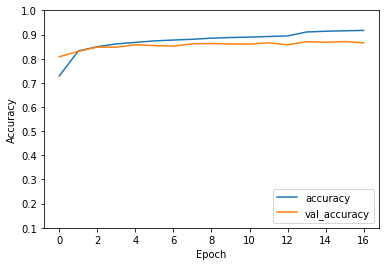

In [101]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

### Visualizing the convolution and pooling filters
This visualization will let us see the features that our neural network learned as it passed through the convolutions. Observe that specific parts of the letter lights up in each layer. We can interpret this as the network identifying those features of the letter

1/1 [==============================] - 0s 59ms/step


C:\Users\aaaab\AppData\Local\Temp\ipykernel_6544\2238644250.py:30: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


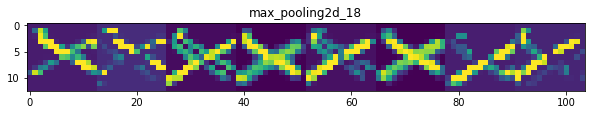

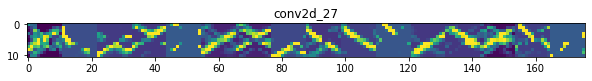

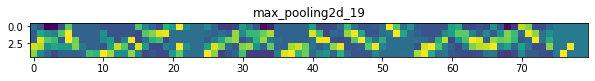

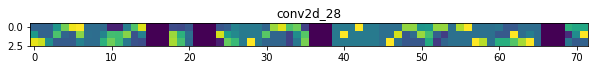

In [109]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import random

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=model.input,
                                            outputs=successive_outputs)

number = random.sample(range(0, len(X_train)), 1)[0]

# Run the image through the network and return the intermediate representations for the data.
successive_feature_maps = visualization_model.predict(
    X_train.iloc[number, :].to_numpy().reshape(1, 28, 28))

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size:(i + 1) * size] = x
        # Display the grid
        scale = 10. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


We can also visualize to see how close our predictions were

3525/3525 [==============================] - 6s 2ms/step
112800


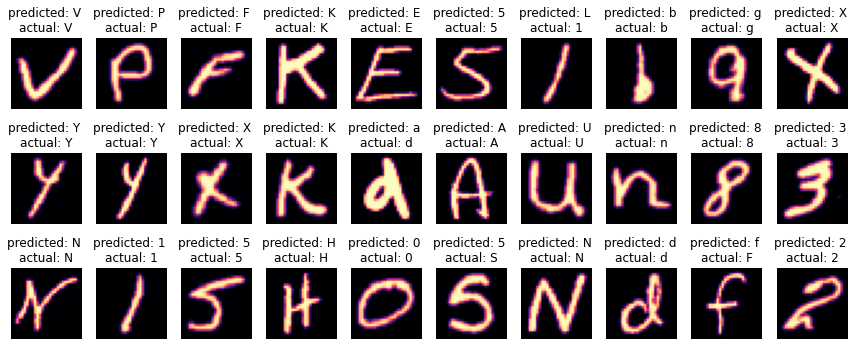

In [123]:
# select random data from test set and predict it's classification
test_samples = random.sample(range(0, len(X_train)), 30)  # select 30 samples
predictions = model.predict(train)

# display results
plt.figure(figsize=(15, 6))
print(len(X_train))
for i in test_samples:
    plt.subplot(3, 10, test_samples.index(i) + 1)
    plt.imshow(train[i].reshape(28, 28), cmap='magma')
    plt.title(f'predicted: {label_dictionary[np.argmax(predictions[i])]} \nactual: {label_dictionary[np.argmax(y_train[i])]}')
    plt.axis('off')

## Part Six: Saving the model

In [124]:
model.save('newmodel',
           save_format='tf',
           include_optimizer=False,
           signatures=None,
           options=None)


INFO:tensorflow:Assets written to: newmodel\assets


INFO:tensorflow:Assets written to: newmodel\assets
